# Detecting COVID-19-Related Fake News Using Traditional Machine Learning Classification Algorithms & Transformer-based Model BERT
**This notebook is part of the Computer Science Engineering MSc Thesis Work (GEIAL536-Ma/2022) at the University of Miskolc, Hungary.*

*Author:* Hamdan Haitam (Neptun: O5BCKN)

*Last modification date:* 2022/05/12

---








#### Notebook Setup

In [ ]:
# Mounting our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Colab offers free to use GPUs and TPUs, and since we will be training a large neural network, it is best to take advantage of this (in this case, we will attach a GPU); otherwise, training will take a very long time.

In [2]:
# Checking wether TensorFlow is using the GPU
import tensorflow as tf
import tensorflow_hub as hub

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
# Checking GPU model (optional)
!nvidia-smi

Thu May 12 12:01:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports & Required Libraries

In [3]:
# SpaCy "langdetect" for language detection => https://spacy.io/universe/project/spacy-langdetect
!pip install spacy-langdetect

In [4]:
# Hugging Face "Transformers" for Fine-tuning BERT => https://huggingface.co/docs/transformers/installation
!pip install transformers

In [5]:
# Essentials
import pandas as pd
import numpy as np
import itertools

# NLP & Preprocessing
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import spacy
from spacy_langdetect import LanguageDetector
import re, unicodedata
from bs4 import BeautifulSoup

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from transformers import BertTokenizer
from transformers import TFAutoModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Data Collection

### Datasets

In this work, we will use a combination of two public datasets: [MM-COVID](https://github.com/bigheiniu/MM-COVID
) and [CoVID19-FNIR](https://ieee-dataport.org/open-access/covid-19-fake-news-infodemic-research-dataset-covid19-fnir-dataset).

*   MM-COVID dataset provides a collection of 3981 multilingual pieces of COVID-19-related fake news content and 7192 trustworthy information from English, Spanish, Portuguese, Hindi, French and Italian, 6 different languages.
*   CoVID19-FNIR dataset contains news stories related to COVID-19
pandemic fact-checked by expert fact-checkers. It consists of fact-checked fake news scraped from [Poynter](https://www.poynter.org/ifcn-covid-19-misinformation/), and true news from the verified Twitter handles of news publishers. The
dataset went through preprocessing steps that included removing special characters and non-vital information.




## Data Preparation

### FNIR

The first step would be to merge our FNIR dataset Real & Fake samples into a single .csv file for better data management.

In [ ]:
# Loading our files
df_fnir_real = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/FNIR/trueNews.csv')
df_fnir_fake = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/FNIR/fakeNews.csv')

In [ ]:
# FNIR Real
df_fnir_real.head()

,Date Posted,Link,Text,Region,Username,Publisher,Label
0,2/11/20,https://twitter.com/the_hindu/status/122725962...,Just in: Novel coronavirus named 'Covid-19': U...,India,the_hindu,The Hindu,1
1,2/12/20,https://twitter.com/ndtv/status/12274908434742...,WHO officially names #coronavirus as Covid-19....,India,ndtv,NDTV,1
2,2/12/20,https://twitter.com/the_hindu/status/122744471...,"The #UN #health agency announced that ""COVID-1...",India,the_hindu,The Hindu,1
3,2/14/20,https://twitter.com/IndiaToday/status/12282764...,The Indian Embassy in Tokyo has said that one ...,India,indiatoday,IndiaToday,1
4,2/15/20,https://twitter.com/the_hindu/status/122854247...,Ground Zero | How Kerala used its experience i...,India,the_hindu,The Hindu,1


In [ ]:
# FNIR Fake
df_fnir_fake.head()

,Date Posted,Link,Text,Region,Country,Explanation,Origin,Origin_URL,Fact_checked_by,Poynter_Label,Binary Label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,France,The screenshot is questionable.,Twitter,https://www.liberation.fr/checknews/2020/02/07...,CheckNews,Misleading,0
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,Germany,Chlorine dioxide does guard against the coron...,Website,https://correctiv.org/faktencheck/medizin-und-...,Correctiv,FALSE,0
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,India,A video shows bats nesting in the roof; howev...,Facebook,https://factcheck.afp.com/video-shows-workmen-...,AFP,MISLEADING,0
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,India,Coronavirus has been around since the 1960s. ...,Twitter,https://www.boomlive.in/health/did-the-simpson...,BOOM FactCheck,Misleading,0
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,India,Chinese President Xi Jinping's visit to the m...,Facebook,http://newsmobile.in/articles/2020/02/07/chine...,NewsMobile,FALSE,0


In [ ]:
# Inspecting shapes

print("FNIR Real: ", df_fnir_real.shape)
print("FNIR Fake: ", df_fnir_fake.shape)

FNIR Real:  (3793, 7)
FNIR Fake:  (3795, 11)


In [ ]:
# Checking the columns
print('Real columns: ', df_fnir_real.columns)
print('Fake columns: ', df_fnir_fake.columns)

Real columns:  Index(['Date Posted', 'Link', 'Text', 'Region', 'Username', 'Publisher',
       'Label'],
      dtype='object')
Fake columns:  Index(['Date Posted', 'Link', 'Text', 'Region', 'Country', 'Explanation',
       'Origin', 'Origin_URL', 'Fact_checked_by', 'Poynter_Label',
       'Binary Label'],
      dtype='object')


In [ ]:
df_fnir_real[['Text', 'Label']]

,Text,Label
0,Just in: Novel coronavirus named 'Covid-19': U...,1
1,WHO officially names #coronavirus as Covid-19....,1
2,"The #UN #health agency announced that ""COVID-1...",1
3,The Indian Embassy in Tokyo has said that one ...,1
4,Ground Zero | How Kerala used its experience i...,1
...,...,...
3788,Global COVID-19 prevention trial of hydroxychl...,1
3789,Bavaria's free COVID-19 test for all splits Ge...,1
3790,Britain locks down city of Leicester after COV...,1
3791,UK imposes lockdown on city of Leicester to cu...,1


In [ ]:
df_fnir_fake[['Text', 'Binary Label']]

,Text,Binary Label
0,Tencent revealed the real number of deaths.\t\t,0
1,Taking chlorine dioxide helps fight coronavir...,0
2,This video shows workmen uncovering a bat-inf...,0
3,The Asterix comic books and The Simpsons pred...,0
4,Chinese President Xi Jinping visited a mosque...,0
...,...,...
3790,Bill Gates said that the COVID-19 vaccine wil...,0
3791,COVID-19 vaccine candidates will insert micro...,0
3792,An image claims that chroma screen panels are...,0
3793,"Alexandria Ocasio-Cortez tweeted, ""It's vital...",0


In [ ]:
# We are only interested in the "Text" and the "Label" for our classification task; therefore, we will drop the rest.
df_fnir_real = df_fnir_real[['Text', 'Label']]
df_fnir_fake = df_fnir_fake[['Text', 'Binary Label']]

In [ ]:
# Renaming columns to avoid merging problems
df_fnir_fake = df_fnir_fake.rename(columns = {'Binary Label': 'Label'})

In [ ]:
# Merging into a single dataframe
df_fnir = pd.concat([df_fnir_real, df_fnir_fake]).reset_index(drop = True)
df_fnir

,Text,Label
0,Just in: Novel coronavirus named 'Covid-19': U...,1
1,WHO officially names #coronavirus as Covid-19....,1
2,"The #UN #health agency announced that ""COVID-1...",1
3,The Indian Embassy in Tokyo has said that one ...,1
4,Ground Zero | How Kerala used its experience i...,1
...,...,...
7583,Bill Gates said that the COVID-19 vaccine wil...,0
7584,COVID-19 vaccine candidates will insert micro...,0
7585,An image claims that chroma screen panels are...,0
7586,"Alexandria Ocasio-Cortez tweeted, ""It's vital...",0


In [ ]:
# Shuffling the dataset (helps avoid the model from getting biased toward the type of content of the last batches)
df_fnir = df_fnir.sample(frac=1).reset_index(drop = True)
df_fnir

,Text,Label
0,Perspective: The Postal Service was in trouble...,1
1,A senior police inspector is infected with CO...,0
2,"Watch | ""Our #coronavirus testing strategy has...",1
3,"Coronavirus: Nearly 9,000 At COVID-19 Risk Fro...",1
4,"An #Italian tourist, who landed here on Februa...",1
...,...,...
7583,"""States like New York, Illinois and Californi...",0
7584,Abascal and Casado have voted to fire Spanish...,0
7585,20 million Chinese people converted to Islam ...,0
7586,#CoronavirusPandemic | COVID-19 cases tally in...,1


In [ ]:
# Finally saving our new dataset file for later use
df_fnir.to_csv('/content/drive/MyDrive/Thesis/Datasets/FNIR/FNIR.csv')

### MM-COVID

In [ ]:
# Loading our dataset
df_mm = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/MM-COVID/MM-COVID.csv')
df_mm

,news_id,agency,claim,fact_url,label,lang,ref_source,ref_source_url,statement
0,webMD-2102578004,webMD,Coronavirus Is a Breeding Ground for Conspirac...,https://www.snopes.com/news/2020/02/28/coronav...,real,en,"{""_id"":{""$oid"":""5f338e26dfd2b7a505e3d5c9""},""id...",https://www.snopes.com/news/2020/02/28/coronav...,Coronavirus Is a Breeding Ground for Conspirac...
1,webMD-3451925886,webMD,COVID-19 and PPE: Some of Us Will Die,https://www.webmd.com/lung/news/20200320/covid...,real,en,"{""_id"":{""$oid"":""5f338e28dfd2b7a505e3d5d2""},""id...",https://www.webmd.com/lung/news/20200320/covid...,COVID19 and PPE Some of Us Will Die
2,webMD-9632391802,webMD,Worldwide Number of COVID-19 Cases Over 1 Million,https://www.webmd.com/lung/news/20200403/world...,real,en,"{""_id"":{""$oid"":""5f338e4bdfd2b7a505e3d635""},""id...",https://www.webmd.com/lung/news/20200403/world...,Worldwide Number of COVID19 Cases Over 1 Million
3,webMD-2255331138,webMD,COVID-19 Likely Seasonal,https://www.webmd.com/lung/news/20200326/covid...,real,en,"{""_id"":{""$oid"":""5f338e4ddfd2b7a505e3d63d""},""id...",https://www.webmd.com/lung/news/20200326/covid...,COVID19 Likely Seasonal
4,webMD-3472860572,webMD,Mobile Apps for Coronavirus (COVID-19),https://www.webmd.com/lung/coronavirus-apps,real,en,"{""_id"":{""$oid"":""5f338e62dfd2b7a505e3d67f""},""id...",https://www.webmd.com/lung/coronavirus-apps,Mobile Apps for Coronavirus COVID19
...,...,...,...,...,...,...,...,...,...
7418,twitter-1232691481430892545,NaN,NaN,NaN,real,en,"{""text"":""Commissioner @SKyriakidesEU met the I...",https://twitter.com/i/web/status/1232691481430...,Commissioner @SKyriakidesEU met the Italian Mi...
7419,twitter-1231981159330066434,NaN,NaN,NaN,real,en,"{""text"":""We are working on all fronts to suppo...",https://twitter.com/i/web/status/1231981159330...,We are working on all fronts to support effort...
7420,twitter-1231866685046566912,NaN,NaN,NaN,real,en,"{""text"":""We are working around the clock to su...",https://twitter.com/i/web/status/1231866685046...,We are working around the clock to support EU ...
7421,twitter-1231855642824134656,NaN,NaN,NaN,real,en,"{""text"":""Statement on the EU’s response, prepa...",https://twitter.com/i/web/status/1231855642824...,"Statement on the EU’s response, preparedness a..."


In [ ]:
# Inspecting the shape & basic stats
print(df_mm.shape)
df_mm.describe()

(7423, 9)


,news_id,agency,claim,fact_url,label,lang,ref_source,ref_source_url,statement
count,7423,4032,4032,4032,7423,7423,7410,7408,7182
unique,7423,65,3950,4003,2,1,6863,7047,6533
top,webMD-2102578004,European Commission,CDC Media Telebriefing: Update on COVID-19,https://www.factcheck.org/2020/04/hoax-letter-...,real,en,"{""text"":""NONE""}",NONE,Press corner
freq,1,539,10,2,5325,7423,517,309,539


In [ ]:
# Checking columns
df_mm.columns

Index(['news_id', 'agency', 'claim', 'fact_url', 'label', 'lang', 'ref_source',
       'ref_source_url', 'statement'],
      dtype='object')

In [ ]:
df_mm[['claim', 'statement', 'label']]

,claim,statement,label
0,Coronavirus Is a Breeding Ground for Conspirac...,Coronavirus Is a Breeding Ground for Conspirac...,real
1,COVID-19 and PPE: Some of Us Will Die,COVID19 and PPE Some of Us Will Die,real
2,Worldwide Number of COVID-19 Cases Over 1 Million,Worldwide Number of COVID19 Cases Over 1 Million,real
3,COVID-19 Likely Seasonal,COVID19 Likely Seasonal,real
4,Mobile Apps for Coronavirus (COVID-19),Mobile Apps for Coronavirus COVID19,real
...,...,...,...
7418,NaN,Commissioner @SKyriakidesEU met the Italian Mi...,real
7419,NaN,We are working on all fronts to support effort...,real
7420,NaN,We are working around the clock to support EU ...,real
7421,NaN,"Statement on the EU’s response, preparedness a...",real


In [ ]:
# Checking how many Fake vs Real values
df_mm['label'].value_counts()

real    5325
fake    2098
Name: label, dtype: int64

Our goal is to have a final dataset by combining MM-COVID with FNIR; therefore, we will have to eliminate the rest of the columns and keep only the news text and the binary label.

In [ ]:
# Dropping unecessary columns
df_mm = df_mm[['statement', 'label']]
df_mm

,statement,label
0,Coronavirus Is a Breeding Ground for Conspirac...,real
1,COVID19 and PPE Some of Us Will Die,real
2,Worldwide Number of COVID19 Cases Over 1 Million,real
3,COVID19 Likely Seasonal,real
4,Mobile Apps for Coronavirus COVID19,real
...,...,...
7418,Commissioner @SKyriakidesEU met the Italian Mi...,real
7419,We are working on all fronts to support effort...,real
7420,We are working around the clock to support EU ...,real
7421,"Statement on the EU’s response, preparedness a...",real


In [ ]:
# Renaming columns
df_mm = df_mm.rename(columns = {'statement': 'Sentence', 'label': 'Label'})
df_mm

,Sentence,Label
0,Coronavirus Is a Breeding Ground for Conspirac...,real
1,COVID19 and PPE Some of Us Will Die,real
2,Worldwide Number of COVID19 Cases Over 1 Million,real
3,COVID19 Likely Seasonal,real
4,Mobile Apps for Coronavirus COVID19,real
...,...,...
7418,Commissioner @SKyriakidesEU met the Italian Mi...,real
7419,We are working on all fronts to support effort...,real
7420,We are working around the clock to support EU ...,real
7421,"Statement on the EU’s response, preparedness a...",real


In [ ]:
# Replace the text labels (real, fake) with their binary representations (0, 1)
df_mm.replace({'Label': "real"}, 1, inplace=True)
df_mm.replace({'Label': "fake"}, 0, inplace=True)

In [ ]:
df_mm['Label'].unique()

array([1, 0])

In [ ]:
# Shuffling the dataset
df_mm = df_mm.sample(frac=1).reset_index(drop = True)
df_mm

,Sentence,Label
0,Train Car carrying COVID-19,0
1,Mayo Clinic QA podcast Precautions for a summe...,1
2,rep lamb conor pa nancy backed pelosi said,0
3,Each of the pillars is crucial but the vaccine...,1
4,plato freedom speech popular ad kong hong china,0
...,...,...
7418,"""Public health is the foundation of social, ec...",1
7419,sacks khans gave denies actor wheat team rs,0
7420,"At this point, we think that a substantial fra...",1
7421,today screenshot extension doctored lockdown,0


In [ ]:
# Finally saving our dataset for later use
df_mm.to_csv('/content/drive/MyDrive/Thesis/Datasets/MM-COVID_new.csv')

In [ ]:
# Loading the new dataset
df_mm = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/MM-COVID_new.csv', index_col=0)
df_mm

,Sentence,Label
0,Train Car carrying COVID-19,0
1,Mayo Clinic QA podcast Precautions for a summe...,1
2,rep lamb conor pa nancy backed pelosi said,0
3,Each of the pillars is crucial but the vaccine...,1
4,plato freedom speech popular ad kong hong china,0
...,...,...
7418,"""Public health is the foundation of social, ec...",1
7419,sacks khans gave denies actor wheat team rs,0
7420,"At this point, we think that a substantial fra...",1
7421,today screenshot extension doctored lockdown,0


In [ ]:
# Final look into our datasets before merging
df_fnir.head()

,Text,Label
0,Perspective: The Postal Service was in trouble...,1
1,A senior police inspector is infected with CO...,0
2,"Watch | ""Our #coronavirus testing strategy has...",1
3,"Coronavirus: Nearly 9,000 At COVID-19 Risk Fro...",1
4,"An #Italian tourist, who landed here on Februa...",1


In [ ]:
df_mm.head()

,Sentence,Label
0,Train Car carrying COVID-19,0
1,Mayo Clinic QA podcast Precautions for a summe...,1
2,rep lamb conor pa nancy backed pelosi said,0
3,Each of the pillars is crucial but the vaccine...,1
4,plato freedom speech popular ad kong hong china,0


In [ ]:
# Rename "Text" to "Sentence"
df_fnir = df_fnir.rename(columns = {'Text': 'Sentence'})
df_fnir.head()

,Sentence,Label
0,Perspective: The Postal Service was in trouble...,1
1,A senior police inspector is infected with CO...,0
2,"Watch | ""Our #coronavirus testing strategy has...",1
3,"Coronavirus: Nearly 9,000 At COVID-19 Risk Fro...",1
4,"An #Italian tourist, who landed here on Februa...",1


In [ ]:
# Finally merging datasets together
df = pd.concat([df_mm, df_fnir]).reset_index(drop = True)
df

,Sentence,Label
0,Train Car carrying COVID-19,0
1,Mayo Clinic QA podcast Precautions for a summe...,1
2,rep lamb conor pa nancy backed pelosi said,0
3,Each of the pillars is crucial but the vaccine...,1
4,plato freedom speech popular ad kong hong china,0
...,...,...
15006,"""States like New York, Illinois and Californi...",0
15007,Abascal and Casado have voted to fire Spanish...,0
15008,20 million Chinese people converted to Islam ...,0
15009,#CoronavirusPandemic | COVID-19 cases tally in...,1


In [ ]:
# Shuffling dataset again
df = df.sample(frac=1).reset_index(drop = True)
df

,Sentence,Label
0,"Again, there are a bunch of assumptions here, ...",1
1,"""Due to the large number of people who will r...",0
2,banner kashmir edited holding hydroxychloroqui...,0
3,"""For individuals, it’s about keeping physical ...",1
4,flu shot false positive covid-19,0
...,...,...
15006,job hiring scam organization kenya coronavirus,0
15007,Just in: 440 fresh cases of COVID-19 raise Wes...,1
15008,Post says no one has died from the coronaviru...,0
15009,Italy's president was caught on camera crying...,0


In [ ]:
# Inspecting the new shape
df.shape

(15011, 2)

In [ ]:
# Checking unique label values
df['Label'].value_counts()

1    9118
0    5893
Name: Label, dtype: int64

In [ ]:
# Saving our final dataset
df.to_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds.csv')

## Data Cleaning

Now, as we are done with the initial preparation of our datasets, it is time to start some necessary data cleaning.

In [ ]:
# Loading our dataset
df = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds.csv', index_col=0)
df

,Sentence,Label
0,"Again, there are a bunch of assumptions here, ...",1
1,"""Due to the large number of people who will r...",0
2,banner kashmir edited holding hydroxychloroqui...,0
3,"""For individuals, it’s about keeping physical ...",1
4,flu shot false positive covid-19,0
...,...,...
15006,job hiring scam organization kenya coronavirus,0
15007,Just in: 440 fresh cases of COVID-19 raise Wes...,1
15008,Post says no one has died from the coronaviru...,0
15009,Italy's president was caught on camera crying...,0


In [ ]:
# Checking for Null/NaN values
df.isna().sum()

Sentence    241
Label         0
dtype: int64

In [ ]:
# Clearing Null/NaN values
df.dropna(inplace=True)
df.isna().sum()

Sentence    0
Label       0
dtype: int64

In [ ]:
df = df.fillna('')

In [ ]:
# Checking for duplicates
df[df.duplicated()].count()

Sentence    981
Label       981
dtype: int64

In [ ]:
# Removing duplicates
df.drop_duplicates(inplace=True)
df[df.duplicated()].count()

Sentence    0
Label       0
dtype: int64

In [ ]:
# Inspecting the new shape & new unique label counts
df.shape

(13789, 2)

In [ ]:
df.describe()

,Label
count,13789.000000
mean,0.601204
std,0.489668
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df['Label'].value_counts()

1    8290
0    5499
Name: Label, dtype: int64

As we can see, our dataset is not quite balanced; therefore, we will have to perform some down-sampling on the "Real (1)" label.

In [ ]:
# Down-sampling to balance dataset
df_real = df[df['Label'] == 1]
df_fake = df[df['Label'] == 0]

In [ ]:
df_real.sample(frac=0.65).reset_index(drop=True)

,Sentence,Label
0,US anti-lockdown rallies could cause surge in ...,1
1,"The FDA said that it has ""determined that the ...",1
2,"Till now, officials have tracked approximately...",1
3,"WHO, @saludhn &amp; partners have agreed and d...",1
4,Until a final call is taken in this regard by ...,1
...,...,...
5383,"However, I'd expect infection-to-case ratio to...",1
5384,传递信息：采取五项措施踢走冠状病毒,1
5385,"Go out, socialize and have fun, South Korea's ...",1
5386,How Mayo Clinic is using artificial intelligen...,1


In [ ]:
# We'll down sample by about 65%
df_real = df_real.sample(frac=0.65).reset_index(drop=True)
df_real.shape

(5388, 2)

In [ ]:
print("Real samples count: ", df_real.shape[0])
print("Fake samples count: ", df_fake.shape[0])

Real samples count:  5388
Fake samples count:  5499


In [ ]:
df = pd.concat([df_real, df_fake]).reset_index(drop = True)
df['Label'].value_counts()

0    5499
1    5388
Name: Label, dtype: int64

#### Non-English Text Removal



As mentioned previously, MM-COVID is a multilingual dataset with more than 5 different languages plus English; therefore, we have to get rid of the rest as we are only interested in English sentences. We can do that using the amazing [SpaCy](https://spacy.io/universe/project/spacy-langdetect) library.

SpaCy provides a fully customizable language detection pipeline that supports more than 17 languages, making it a suitable option for our task.

In [ ]:
# SpaCy language detection function
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text = df['Sentence'].astype('str')
lang = []

for e in text:
    doc = nlp(e)
    
    if doc._.language:
        lang.append(doc._.language.get('language'))
    else:
        lang.append('unknown')

In [ ]:
# Assigning the results to a new column "Language"
df['Language'] = lang

In [ ]:
df[df['Language'] != 'en']

,Sentence,Label,Language
114,https://twitter.com/trvrb/status/125344728536...,1,UNKNOWN
120,¿Estás interesado en ser un voluntario para un...,1,es
168,国际社会承诺支持为抗击COVID19开放科学研究成果,1,zh-cn
203,Incentivo extraordinário à normalização da ati...,1,pt
209,El COI aúna fuerzas con la OMS y las Naciones ...,1,es
...,...,...,...
10809,"A Twitter post titled ""Sakam da kazam""",0,tr
10820,circuit board covid covid,0,ro
10852,accepts quran covid covid,0,ca
10860,Helicopters disinfectants coronavirus,0,ca


In [ ]:
# Checking how many English vs Non-English sentences
df['Language'].value_counts()

en         10219
it           129
es           116
fr           106
ca            85
ro            42
zh-cn         19
id            18
pt            18
da            17
nl            15
et            13
af            11
lt             8
sv             8
ko             7
de             7
tl             7
sl             6
no             5
hr             5
fi             4
cy             4
so             4
sk             3
sw             2
th             2
pl             2
UNKNOWN        2
vi             1
cs             1
tr             1
Name: Language, dtype: int64

In [ ]:
# Dropping Non-English text
df = df[df['Language'] == 'en']

In [ ]:
# Removing the extra column
df.drop('Language', axis=1, inplace=True)

In [ ]:
df['Label'].value_counts()

1    5286
0    4933
Name: Label, dtype: int64

In [ ]:
# Quick shuffle before save
df = df.sample(frac=1).reset_index(drop = True)
df

,Sentence,Label
0,Thank you. I perhaps could have been clearer t...,1
1,islam convert seeking millions co chinese,0
2,Delhi Health Minister Satyendar Jain said tha...,0
3,Existence of a vaccination summit may be a si...,0
4,"So far, WHO has declared a Public Health Emerg...",1
...,...,...
10214,What if immunity to covid19 doesn’t last,1
10215,U.N. warns of global mental health crisis due ...,1
10216,Thinking about ditching the regular bread for ...,1
10217,Thank you for your concern regarding this imag...,1


In [ ]:
# We got a fairly balanced dataset now, so it's time to save the file for later use
df.to_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds_balanced.csv')

### Text Preprocessing


The next step is to perform some necessary text cleaning. We have taken measures like getting rid of URLs, punctuation, emojis, stop-words, etc.

In [ ]:
# Loading the new dataset

df = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds_balanced.csv', index_col=0)
df.head()

,Sentence,Label
0,Thank you. I perhaps could have been clearer t...,1
1,islam convert seeking millions co chinese,0
2,Delhi Health Minister Satyendar Jain said tha...,0
3,Existence of a vaccination summit may be a si...,0
4,"So far, WHO has declared a Public Health Emerg...",1


In [ ]:
# Example sentence before preprocessing
df['Sentence'][10]

'The total number of #coronavirus cases in #Dharavi reached 28 while four people have died due to the deadly virus so far.\n#Maharashtra #Mumbai #COVID__19 https://www.indiatoday.in/india/story/mumbai-police-barricades-dharavi-area-amid-rising-covid-19-cases-1666103-2020-04-12\xa0'

In [ ]:
# English stopwords required for preprocessing => https://www.nltk.org/data.html
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 1. Cleaning html-scrapped text/unicode characters
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_unicode(text):
    return unicodedata.normalize("NFKD",BeautifulSoup(text, "lxml").text)

# 2. Removing URLs
def rem_urls(text):
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)
    return text

#3. Removing punctuation, special characters & numbers
def rem_punc(text):
    return re.sub('[^A-Za-z]+', ' ', text)

# 4. Making sure any double-spaces are single
def rem_dspaces(text):
    return re.sub('  ',' ', text)

# 5. Transforming all text to lowercase
def to_lower(text):
    return text.lower()

# 6. Removing stop words
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return ' '.join(final_text)

# Final function to clean everything
def clean_data(text):
    text = strip_html(text)
    text = rem_urls(text)
    text = clean_unicode(text)
    text = rem_punc(text)
    text = rem_dspaces(text)
    text = to_lower(text)
    text = remove_stopwords(text)
    return text

In [ ]:
# Applying the function on our sentence column
df["Sentence"] = df["Sentence"].apply(clean_data)

In [ ]:
# Example sentence after preprocessing
df['Sentence'][10]

'total number coronavirus cases dharavi reached four people died due deadly virus far maharashtra mumbai covid'

In [ ]:
# Saving our preprocessed dataset
df.to_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds_balanced_preprocessed.csv')

## Data Exploration/Visualization

Now, our data is balanced, cleaned, and ready for visualization.

In [ ]:
# Loading newly saved dataset

df = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds_balanced_preprocessed.csv', index_col=0)
df.head()

,Sentence,Label
0,thank perhaps could clearer significant digits...,1
1,islam convert seeking millions co chinese,0
2,delhi health minister satyendar jain said sing...,0
3,existence vaccination summit may sign vaccinat...,0
4,far declared public health emergency internati...,1


### Fake vs Real

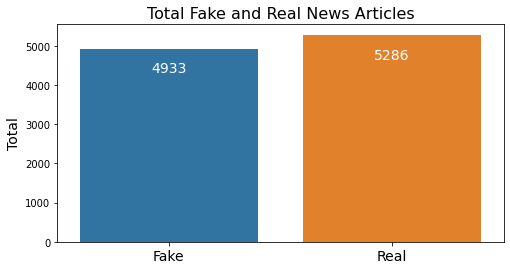

1    5286
0    4933
Name: Label, dtype: int64


In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x = df['Label'])
plt.title('Total Fake and Real News Articles', fontsize=16)
plt.ylabel('Total', fontsize=14)
plt.xlabel('')
plt.xticks([0, 1], ['Fake', 'Real'], fontsize=14)

for bar in ax.patches:
   
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=14, xytext=(0, -20),
                   textcoords='offset points', color='white')
plt.show()
print(df['Label'].value_counts())

### Word Clouds

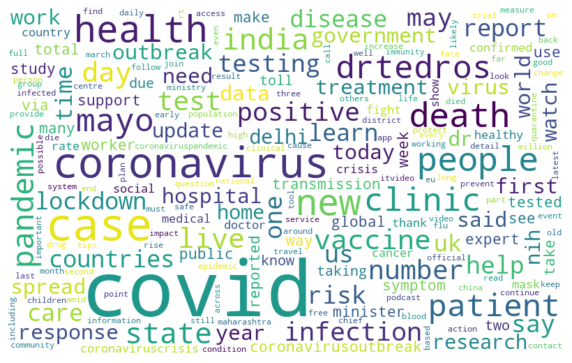

In [ ]:
# Real News
real_data = df[df['Label'] == 1]
all_words = ' '.join([str(text) for text in real_data['Sentence']])

wordcloud = WordCloud(width= 800, height= 500,
                          background_color ='white',
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

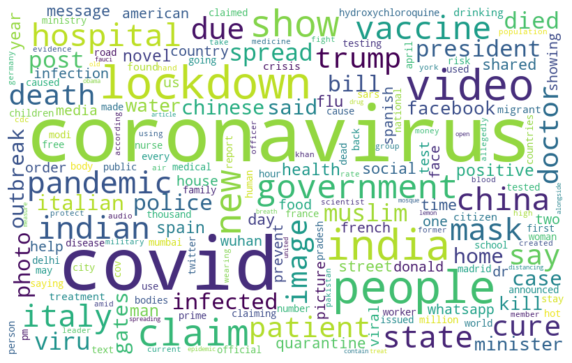

In [ ]:
# Fake News
fake_data = df[df['Label'] == 0]
all_words = ' '.join([str(text) for text in fake_data['Sentence']])

wordcloud = WordCloud(width= 800, height= 500,
                          background_color ='white',
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Frequent Words

In [ ]:
# Function to separate our words into tokens, then plot them
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity, plot_color):
    all_words = ' '.join(map(str, [text for text in text[column_text]]))
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Frequency", y = "Word", color = plot_color)
    ax.set_xlabel('Frequency', fontsize = 14)
    ax.set_ylabel('Words', fontsize = 14)
    plt.xticks(rotation='horizontal')

    plt.show()

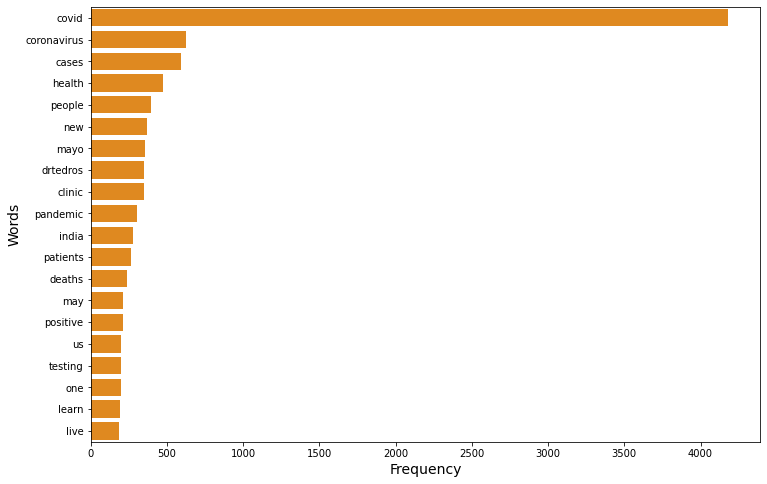

In [ ]:
# 20th Most frequent Real News words
counter(df[df['Label'] == 1], 'Sentence', 20, 'darkorange')

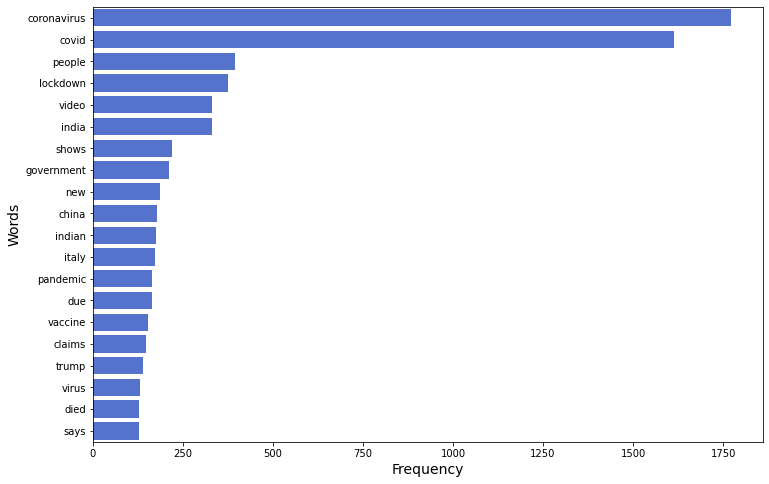

In [ ]:
# 20th Most frequent Fake News words
counter(df[df['Label'] == 0], 'Sentence', 20, 'royalblue')

## Classification - Machine Learning Models

At this point, we are ready to train our models and implement our data classification.

### Training

In [ ]:
# First, we need to split the data
X = df['Sentence']
y = df['Label']

# We use 90% for training, the rest for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y, random_state=42)

In [ ]:
print('Train size: ', len(X_train))
print('Test size: ', len(X_test))

Train size:  9196
Test size:  1022


### Feature Extraction

Before training our models, we have to convert our preprocessed (tokenized) text into numerical text so that our model can understand and make correct predictions. This process is called "Vectorization".

#### Count Vectorizer (Bag of Words)

Bag of Words (BoW) counts the number of times a token shows up in the document (refers to text objects which make our corpus) and uses this value as its weight. The more the word frequency, the less its importance in the document.

In [ ]:
# Initializing the CountVectorizer 
count_vectorizer = CountVectorizer(stop_words='english')

# Fitting and transforming the training data 
cv_train = count_vectorizer.fit_transform(X_train) 

# Transforming the test set 
cv_test = count_vectorizer.transform(X_test)

In [ ]:
# Example of extracted feature names of CountVectorizer
print(count_vectorizer.get_feature_names_out()[:50])

['aa' 'aaf' 'aaj' 'aajtak' 'aamir' 'aap' 'aapmhq' 'aarogyasetu'
 'aarogyasetuapp' 'aata' 'aatmnirbharbharatabhiyaan' 'aayog' 'ab' 'aba'
 'ababa' 'abandon' 'abandoned' 'abandonment' 'abascal' 'abate'
 'abbazubairmd' 'abbott' 'abbreviation' 'abbyhaglage' 'abc' 'abdel'
 'abdomen' 'abdominal' 'abdullah' 'abdulwahab' 'abe' 'abengibre' 'abf'
 'abhigyan' 'abide' 'abiding' 'abigail' 'ability' 'abinash' 'ablaze'
 'able' 'ablution' 'abnormal' 'abnormalities' 'aboard' 'abolish' 'aborted'
 'abortion' 'abou' 'abp']


#### TF-IDF Vectorizer

TF-IDF or “Term Frequency-Inverse Document Frequency” is a numerical statistic intended to demonstrate the importance of a word to a document in a collection or corpus by calculating the score for that word.

In [ ]:
# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english') 

# Fitting and transforming the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transforming the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# Example of extracted feature names of TfidfVectorizer
print(tfidf_vectorizer.get_feature_names_out()[-50:])

['yong' 'york' 'yorker' 'youknowwheretogo' 'young' 'younger' 'youth'
 'youthday' 'youtube' 'youyang' 'youyanggu' 'yrs' 'ys' 'yugayatri'
 'yunnan' 'yves' 'zaev' 'zagreb' 'zahoor' 'zali' 'zambia' 'zamora'
 'zaragoza' 'zealand' 'zealanders' 'zee' 'zeratsky' 'zero' 'zeynep'
 'zhang' 'zhen' 'zika' 'zimbabwean' 'zinc' 'zindabad' 'zip'
 'zkayeobtqwvsygizsfoptx' 'zlotys' 'zone' 'zones' 'zoo' 'zookeepers'
 'zookeeping' 'zoology' 'zoom' 'zoran' 'zpac' 'zucchini' 'zurich' 'zyphr']


### Evaluation & Results

In [ ]:
# Function to plot the Confusion Matrices
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       493
           1       0.90      0.91      0.91       529

    accuracy                           0.90      1022
   macro avg       0.90      0.90      0.90      1022
weighted avg       0.90      0.90      0.90      1022

Confusion matrix, without normalization


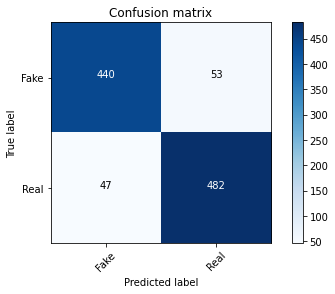

In [ ]:
# Using CountVectorizer
lreg = LogisticRegression()
lreg.fit(cv_train, y_train)
lreg_pred = lreg.predict(cv_test)
lreg_report = classification_report(y_test, lreg_pred, target_names = ['0','1'])
print(lreg_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, lreg_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       493
           1       0.86      0.92      0.89       529

    accuracy                           0.88      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.88      0.88      0.88      1022

Confusion matrix, without normalization


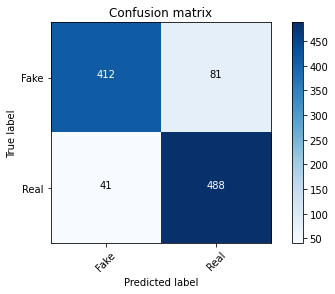

In [ ]:
# Using TF-IDF
lreg = LogisticRegression()
lreg.fit(tfidf_train, y_train)
lreg_pred = lreg.predict(tfidf_test)
lreg_report = classification_report(y_test, lreg_pred, target_names = ['0','1'])
print(lreg_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, lreg_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

#### Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       493
           1       0.88      0.94      0.91       529

    accuracy                           0.90      1022
   macro avg       0.91      0.90      0.90      1022
weighted avg       0.91      0.90      0.90      1022

Confusion matrix, without normalization


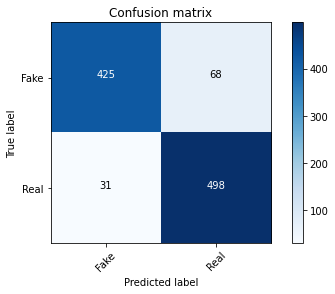

In [ ]:
# Using CountVectorizer
mnb = MultinomialNB()
mnb.fit(cv_train, y_train)
mnb_pred = mnb.predict(cv_test)
mnb_report = classification_report(y_test, mnb_pred, target_names = ['0','1'])
print(mnb_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, mnb_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       493
           1       0.87      0.95      0.91       529

    accuracy                           0.90      1022
   macro avg       0.91      0.90      0.90      1022
weighted avg       0.91      0.90      0.90      1022

Confusion matrix, without normalization


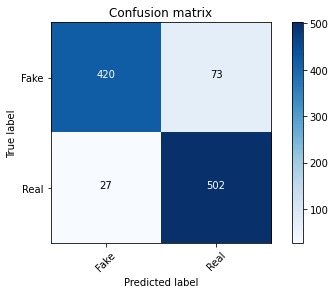

In [ ]:
# Using TF-IDF
mnb = MultinomialNB()
mnb.fit(tfidf_train, y_train)
mnb_pred = mnb.predict(tfidf_test)
mnb_report = classification_report(y_test, mnb_pred, target_names = ['0','1'])
print(mnb_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, mnb_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

#### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       493
           1       0.83      0.89      0.86       529

    accuracy                           0.85      1022
   macro avg       0.85      0.85      0.85      1022
weighted avg       0.85      0.85      0.85      1022

Confusion matrix, without normalization


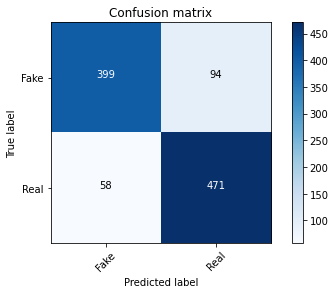

In [ ]:
# Using CountVectorizer
dt = DecisionTreeClassifier()
dt.fit(cv_train, y_train)
dt_pred = dt.predict(cv_test)
dt_report = classification_report(y_test, dt_pred, target_names = ['0','1'])
print(dt_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       493
           1       0.81      0.86      0.84       529

    accuracy                           0.83      1022
   macro avg       0.83      0.82      0.83      1022
weighted avg       0.83      0.83      0.83      1022

Confusion matrix, without normalization


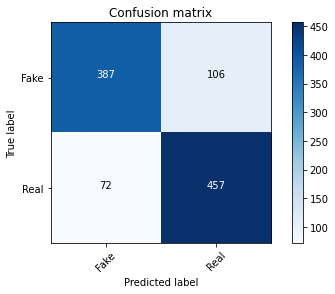

In [ ]:
# Using TF-IDF
dt = DecisionTreeClassifier()
dt.fit(tfidf_train, y_train)
dt_pred = dt.predict(tfidf_test)
dt_report = classification_report(y_test, dt_pred, target_names = ['0','1'])
print(dt_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

#### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       493
           1       0.88      0.90      0.89       529

    accuracy                           0.88      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.88      0.88      0.88      1022

Confusion matrix, without normalization


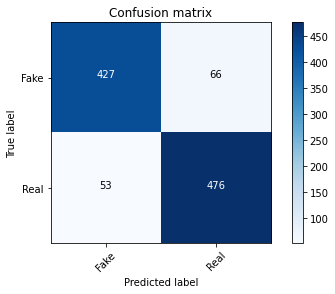

In [ ]:
# Using CountVectorizer
rf = RandomForestClassifier()
rf.fit(cv_train, y_train)
rf_pred = rf.predict(cv_test)
rf_report = classification_report(y_test, rf_pred, target_names = ['0','1'])
print(rf_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       493
           1       0.87      0.90      0.89       529

    accuracy                           0.88      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.88      0.88      0.88      1022

Confusion matrix, without normalization


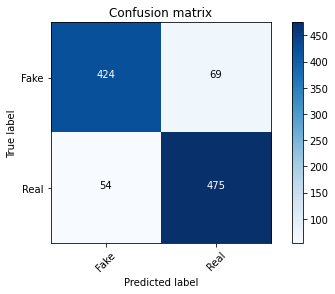

In [ ]:
# Using TF-IDF
rf = RandomForestClassifier()
rf.fit(tfidf_train, y_train)
rf_pred = rf.predict(tfidf_test)
rf_report = classification_report(y_test, rf_pred, target_names = ['0','1'])
print(rf_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

#### Passive-Aggressive Classifier

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       493
           1       0.88      0.88      0.88       529

    accuracy                           0.88      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.88      0.88      0.88      1022

Confusion matrix, without normalization


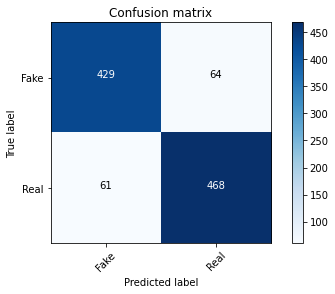

In [ ]:
# Using CountVectorizer
pa = PassiveAggressiveClassifier(max_iter=50)
pa.fit(cv_train, y_train)
pa_pred = pa.predict(cv_test)
pa_report = classification_report(y_test, pa_pred, target_names = ['0','1'])
print(pa_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, pa_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       493
           1       0.87      0.90      0.88       529

    accuracy                           0.88      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.88      0.88      0.88      1022

Confusion matrix, without normalization


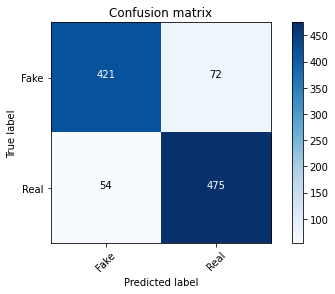

In [ ]:
# Using TF-IDF
pa = PassiveAggressiveClassifier(max_iter=50)
pa.fit(tfidf_train, y_train)
pa_pred = pa.predict(tfidf_test)
pa_report = classification_report(y_test, pa_pred, target_names = ['0','1'])
print(pa_report)

# Printing Confusion Matrix
cm = confusion_matrix(y_test, pa_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
# Comparing our classification models

# Accuracy Score
as_lreg = round(accuracy_score(y_test, lreg_pred) * 100, 2)
as_mnb = round(accuracy_score(y_test, mnb_pred) * 100, 2)
as_dt = round(accuracy_score(y_test, dt_pred) * 100, 2)
as_rf = round(accuracy_score(y_test, rf_pred) * 100, 2)
as_pa = round(accuracy_score(y_test, pa_pred) * 100, 2)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Naive Bayes', 
              'Decision Tree',
              'Random Forest',  
              'Passive-Aggressive'
              ],
    "Accuracy":[as_lreg,
                      as_mnb,
                      as_dt,
                      as_rf,
                      as_pa,
                     ]})
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.reset_index(drop=True)
result_df

,Model,Accuracy
0,Naive Bayes,90.22
1,Logistic Regression,88.06
2,Random Forest,87.96
3,Passive-Aggressive,87.67
4,Decision Tree,82.58


## Classification - Deep Learning Model

In the next section, we will demonstrate how we can use [BERT](https://github.com/google-research/bert) to quickly and efficiently fine-tune a model to get near state-of-the-art performance in text classification.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018 by Google's AI team, is a deep learning model of pretraining language representations used to create state-of-the-art models that NLP practitioners can download and use for free.

BERT can extract high-quality language features from text data. It can be fine-tuned on a specific task (classification, entity recognition, question answering, etc.) using your own data to produce state-of-the-art predictions.

![bert_mountain.png](https://msank00.github.io/assets/images/image_39_bert_03.png) 

`Image Source: `https://msank00.github.io/blog/2020/04/13/blog_607_Survey_BERT








### Understanding BERT

#### BERT Paper

**Paper:** [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)

**Submitted:** Oct 11, 2018

**First Author:** Jacob Devlin, Google AI Language

![bert_paper.png](http://mccormickml.com/assets/BERT/bert_paper.png)

#### Transformer Architecture Paper

The following article is the paper that introduced the "Transformer" architecture. We can say that basically, BERT is just a big stack of Transformers.

**Paper:** [Attention is all you need](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)

**Submitted:** Jun 12, 2017

**First Author:** Ashish Vaswani, Google Brain

![transformer_paper.png](http://mccormickml.com/assets/BERT/transformer_paper.png)

#### Useful Resources

[Jay Alammar](https://github.com/jalammar) made an amazing job explaining BERT architecture in detail; his blog posts are well written and very “readable”, largely due to his excellent illustrations.

* **BERT** —— [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
* **Transformer** —— [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
* **Attention** —— [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)


#### Advantages of Fine-tuning with BERT

We will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on end, and train the new model for our classification task. Why do this rather than train a specific deep learning model (a CNN, BiLSTM, etc.) well suited for the specific NLP task you need?

1. **Quicker Development**

    * Thanks to the pre-trained BERT model, the weights already encode much information about our language. As a result, it would take much less time to train our fine-tuned model. An example would be if we have already trained the bottom layers of our network extensively and only need to tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT (compared to the hundreds of GPU hours needed to train the original BERT model or an LSTM from scratch).

2. **Less Data**

    * BERT’s pre-trained weights allow us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset to train our network to reasonable accuracy, resulting in a lot of time and energy that must be put into dataset creation.

3. **Better Results**

    * Finally, BERT’s simple fine-tuning procedure (typically adding one fully connected layer on top of BERT and training for a few epochs) was shown to achieve the state-of-the-art results with minimal task-specific adjustments for a wide variety of tasks, rather than implementing custom or obscure architectures shown to work well on a specific task.

### BERT Setup

Text inputs need to be transformed to numeric token ids and arranged in several tensors before being input to BERT. BERT comes with its own preprocessor; therefore, we will use the non-preprocessed dataset.

In [25]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/thesis_ds_balanced.csv', index_col=0)
df

,Sentence,Label
0,Thank you. I perhaps could have been clearer t...,1
1,islam convert seeking millions co chinese,0
2,Delhi Health Minister Satyendar Jain said tha...,0
3,Existence of a vaccination summit may be a si...,0
4,"So far, WHO has declared a Public Health Emerg...",1
...,...,...
10214,What if immunity to covid19 doesn’t last,1
10215,U.N. warns of global mental health crisis due ...,1
10216,Thinking about ditching the regular bread for ...,1
10217,Thank you for your concern regarding this imag...,1


We still have to do some basic text preprocessing to eliminate URLs and unicode characters. However, we will keep stopwords as context is required for BERT.

In [26]:
# 1. Cleaning html-scrapped text/unicode characters
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_unicode(text):
    return unicodedata.normalize("NFKD",BeautifulSoup(text, "lxml").text)

# 2. Removing URLs
def rem_urls(text):
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)
    return text

# 3. Making sure any double-spaces are single
def rem_dspaces(text):
    return re.sub('  ',' ', text)

# 4. Transforming all text to lowercase
def to_lower(text):
    return text.lower()

# Final function to clean everything
def clean_data(text):
    text = strip_html(text)
    text = rem_urls(text)
    text = clean_unicode(text)
    text = rem_dspaces(text)
    text = to_lower(text)
    return text

In [27]:
# Applying the function on our sentence column
df["Sentence"] = df["Sentence"].apply(clean_data)

#### Required Formatting

In order to feed our text sentences to BERT, they must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. The tokenization must be performed by the tokenizer included with BERT. We will be using the "[uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4)" version here.

In [29]:
# Loading the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [28]:
# Getting the lists of sentences and their labels.
sentences = df['Sentence'].values
labels = df['Label'].values

Let us apply the tokenizer to one sentence for demonstration just to see the output.

In [30]:
# Original sentence.
print('Original: ', sentences[10])

# Sentence split into tokens.""
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  the total number of #coronavirus cases in #dharavi reached 28 while four people have died due to the deadly virus so far.
#maharashtra #mumbai #covid__19  
Tokenized:  ['the', 'total', 'number', 'of', '#', 'corona', '##virus', 'cases', 'in', '#', 'dh', '##ara', '##vi', 'reached', '28', 'while', 'four', 'people', 'have', 'died', 'due', 'to', 'the', 'deadly', 'virus', 'so', 'far', '.', '#', 'maharashtra', '#', 'mumbai', '#', 'co', '##vid', '_', '_', '19']
Token IDs:  [4067, 2017, 1012, 1045, 3383, 2071, 2031, 2042, 24509, 2008, 1523, 1014, 1012, 1014, 1003, 1524, 2003, 3278, 16648, 3574, 1026, 1015, 1013, 6694, 2738, 2084, 2995, 5717, 1012]


We are required to do the following:

* Add the special tokens to the start and end of each sentence.
* Pad & truncate all sentences to a single constant length.
* Explicitly differentiate real tokens from padding tokens using the "attention mask".

##### Special Tokens

**`[SEP]`**

We need to append the special `[SEP]` token at the end of every sentence. This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine the following phrase.

**`[CLS]`**

The first token of every sequence is always a unique classification token `[CLS]`. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings and produces the same number of embeddings on the output. On the output of the final 12th transformer, only the classifier uses the first embedding (corresponding to the `[CLS]` token).

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

`Image source:` http://mccormickml.com/2019/07/22/BERT-fine-tuning/

##### Sentence Length & Attention Mask

The sentences in our dataset clearly have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is merely an array of 1s and 0s indicating which tokens are padding and which are not.

`Image source:` http://mccormickml.com/2019/07/22/BERT-fine-tuning/

#### Tokenization

In [31]:
max_seq_length = 256 # Sentence Length for the padding token [PAD]
num_samples = len(df) # Total number of samples
X_input_ids = np.zeros((num_samples, max_seq_length)) # Generating an "Input ids" numpy array
X_attn_masks = np.zeros((num_samples, max_seq_length)) # Generating an "Attention masks" numpy array

In [32]:
X_input_ids.shape

(10219, 256)

In [33]:
X_input_ids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
# Tokenizing all our sentences
for i, sentence in enumerate(df['Sentence']):
  tokenized_sentence = tokenizer.encode_plus(sentence, 
                                 max_length = max_seq_length,
                                 truncation = True,
                                 padding = 'max_length', 
                                 add_special_tokens = True,
                                 return_tensors = 'tf')
  X_input_ids[i, :] = tokenized_sentence['input_ids']
  X_attn_masks[i, :] = tokenized_sentence['attention_mask']

In [35]:
print('Sentence: ', sentences[10])
print('Input ids: ', X_input_ids[10])
print('Attention masks', X_attn_masks[10])

# [CLS] => 101
# [SEP] => 102
# [PAD] => 0 (zeros)

Sentence:  the total number of #coronavirus cases in #dharavi reached 28 while four people have died due to the deadly virus so far.
#maharashtra #mumbai #covid__19  
Input ids:  [  101.  1996.  2561.  2193.  1997.  1001. 21887. 23350.  3572.  1999.
  1001. 28144.  5400.  5737.  2584.  2654.  2096.  2176.  2111.  2031.
  2351.  2349.  2000.  1996.  9252.  7865.  2061.  2521.  1012.  1001.
 12434.  1001.  8955.  1001.  2522. 17258.  1035.  1035.  2539.   102.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     

#### Label Encoding

In [36]:
# Saving our classes into a variable
classes = df['Label'].values
classes

array([1, 0, 0, ..., 1, 1, 0])

In [37]:
# Creating a numpy array filled with zeros for our labels
labels = np.zeros((num_samples, classes.max() + 1))
labels.shape

(10219, 2)

In [38]:
# Applying One-Hot Encoding
labels[np.arange(num_samples), classes] = 1
labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

#### Modeling

Now that our input data is formatted correctly, it is time to fine-tune the BERT model.

##### Train/Test Split

In [39]:
# Creating a data pipeline using TensorFlow dataset utility. It creates batches of data for easy loading
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # One sample of data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [40]:
# Creating a map function to map our tensors to inputs
def mapTensorToInput(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [41]:
# Setup batch size, drop any left out tensor

dataset = dataset.map(mapTensorToInput)
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [42]:
# For each 16 batch of data we will have (number of samples / batch size) samples, we take 70/15/15.
train_size = int((num_samples / batch_size) * 0.7)
val_size = int((num_samples / batch_size) * 0.15)
test_size = int((num_samples / batch_size) * 0.15)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

print('Number of samples: ', num_samples)
print('Train size: ', train_size)
print('Validation size: ', val_size)
print('Test size: ', test_size)

Number of samples:  10219
Train size:  447
Validation size:  95
Test size:  95


##### Building our NN Model

In [43]:
# Loading our bert base model with pretrained weights
model = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [44]:
# Defining our layers
input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(max_seq_length,), name='attention_mask', dtype='int32')

bert_embeds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> Activation layer (3D), 1 -> Pooled Output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(2, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> Calcs probs of labels

BERT_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
BERT_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

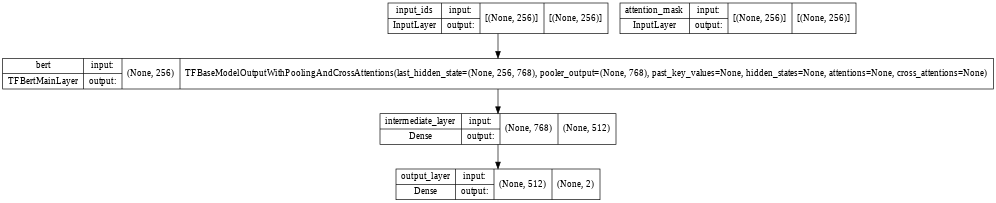

In [45]:
tf.keras.utils.plot_model(BERT_model, show_shapes=True, dpi=48)

##### Setup Optimizer & Loss Function

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 16).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We will use 2e-5).
- Number of epochs: 2, 3, 4  (We will use 3).

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

#### Training & Evaluation

In [47]:
# Compiling our model
BERT_model.compile(optimizer=optimizer, loss=loss_func, metrics=[accuracy])

In [48]:
# Fitting the model
history = BERT_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
447/447 [==============================] - 392s 857ms/step - loss: 0.1221 - accuracy: 0.9525 - val_loss: 0.0290 - val_accuracy: 0.9915
Epoch 2/3
447/447 [==============================] - 387s 865ms/step - loss: 0.0429 - accuracy: 0.9863 - val_loss: 0.0197 - val_accuracy: 0.9941
Epoch 3/3
447/447 [==============================] - 387s 866ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.0132 - val_accuracy: 0.9967


In [49]:
# Evaluating our model
loss, accuracy = BERT_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

95/95 [==============================] - 27s 281ms/step - loss: 0.0159 - accuracy: 0.9967
Loss: 0.01593724638223648
Accuracy: 0.9967105388641357


In [50]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

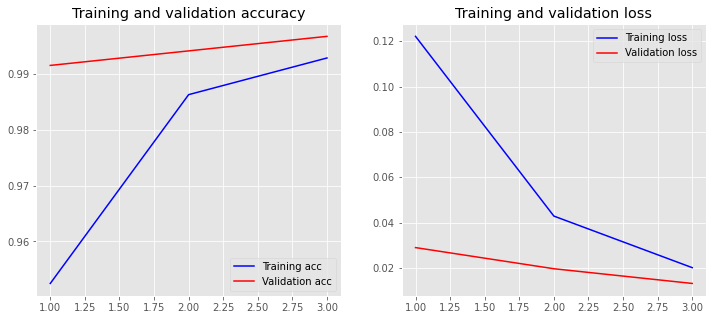

In [51]:
plot_history(history)

In [52]:
# Finally saving our model for later use
BERT_model.save('/content/drive/MyDrive/Thesis/BERT_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/BERT_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/BERT_model/assets


#### Prediction



In [54]:
# Let's load our model
fake_news_model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/BERT_model')

In [55]:
# Before we make prediction, we have to tokenize our input text first
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text):
    tokenized_text = tokenizer.encode_plus(
        input_text,
        max_length = 256, 
        truncation = True, 
        padding = 'max_length', 
        add_special_tokens = True,
        return_token_type_ids = False,
        return_tensors = 'tf'
    )
    return {
        'input_ids': tf.cast(tokenized_text['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokenized_text['attention_mask'], tf.float64)
    }

In [56]:
classes = ['Fake', 'Real']

In [59]:
# Fake news prediction

fake_news_text = "Coronavirus Hoax: Fake Virus Pandemic Fabricated to Cover-Up Global Outbreak of 5G Syndrome."
processed_text = prepare_data(fake_news_text)
probs = fake_news_model.predict(processed_text)
label = np.argmax(probs[0])
print('This news is: ', classes[label])
print('Score: ', probs[0])

This news is:  Fake
Score:  [0.9977608  0.00223925]


In [57]:
# Real news prediction
# News source: https://www.theguardian.com/world/2022/may/12/north-korea-admits-to-covid-outbreak-for-first-time

real_news_text = "North Korea admits to Covid outbreak for first time and declares severe national emergency."
processed_text = prepare_data(real_news_text)
probs = fake_news_model.predict(processed_text)
label = np.argmax(probs[0])
print('This news is: ', classes[label])
print('Score: ', probs[0])

This news is:  Real
Score:  [0.06693849 0.9330615 ]
